<b>Objective</b>: Your goal is to build a robust, end to end machine learning pipeline to
predict house prices for the King County dataset. This assignment requires you to
move beyond the manual steps in the original notebook and implement a more
sophisticated, automated preprocessing workflow using Scikit Learn's Pipeline and
ColumnTransformer. You will also perform advanced feature engineering and
hyperparameter tuning to maximize model performance.

<b>Task 1</b>: Advanced Exploratory Data Analysis (EDA) & Feature Engineering
Before building the model, you must deeply understand and enrich the dataset.
Introduce and Handle Missing Data: The original dataset is clean. Real world data
is not. To simulate this, randomly introduce approximately 5% missing values into
the sqft_lot and bathrooms columns. You'll need to devise an imputation strategy
for these later in your pipeline.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [59]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [60]:
df.isnull().sum()


id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<b>1. Outlier Detection and Handling:</b><br>
○ Create boxplots for price, sqft_living, and bedrooms.<br>
○ Identify and remove egregious outliers. A common rule is to remove
data points that lie beyond 1.5timesIQR (Interquartile Range) from the
first or third quartile. Justify your outlier removal strategy. For
instance, does a house with 33 bedrooms seem plausible?

In [61]:
plt.figure(figsize=(15,5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0.5, 1.0, 'Boxplot - Price')

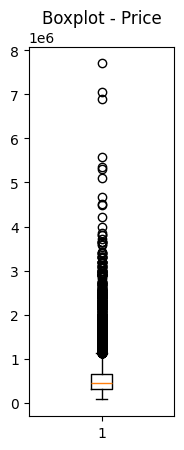

In [62]:
plt.subplot(1, 3, 1)
plt.boxplot(df['price'])
plt.title("Boxplot - Price")

Text(0.5, 1.0, 'Boxplot - Sqft Living')

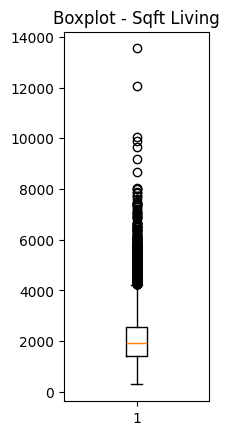

In [63]:
plt.subplot(1, 3, 2)
plt.boxplot(df['sqft_living'])
plt.title("Boxplot - Sqft Living")

Text(0.5, 1.0, 'Boxplot - Bedrooms')

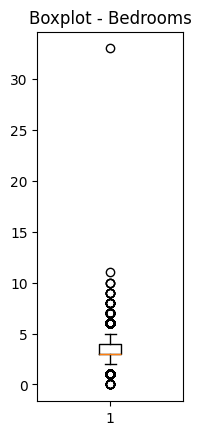

In [64]:
plt.subplot(1,3,3)
plt.boxplot(df['bedrooms'])
plt.title("Boxplot - Bedrooms")

In [65]:
plt.show()

In [66]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 -Q1
lowp = Q1 - 1.5*IQR
highp = Q3 +1.5*IQR

In [67]:
Q1 = df['sqft_living'].quantile(0.25)
Q3 = df['sqft_living'].quantile(0.75)
IQR = Q3 -Q1
lows = Q1 - 1.5*IQR
highs = Q3 +1.5*IQR

In [68]:
Q1 = df['bedrooms'].quantile(0.25)
Q3 = df['bedrooms'].quantile(0.75)
IQR = Q3 -Q1
lowb = Q1 - 1.5*IQR
highb = Q3 +1.5*IQR

In [69]:
df_clean = df[
    (df['price'] >=lowp) & (df['price'] <= highp) &
    (df['sqft_living'] >=lows) & (df['sqft_living'] <= highs) &
    (df['bedrooms'] >=lowb) & (df['bedrooms'] <= highb)
]

In [70]:
print("Before removal:", df.shape)
print("After removal:", df_clean.shape)

Before removal: (21613, 21)
After removal: (19817, 21)


In [71]:
print("Max bedrooms before:", df["bedrooms"].max())
print("Max bedrooms after :", df_clean["bedrooms"].max())

print("Max sqft_living before:", df["sqft_living"].max())
print("Max sqft_living after :", df_clean["sqft_living"].max())

print("Max price before:", df["price"].max())
print("Max price after :", df_clean["price"].max())

Max bedrooms before: 33
Max bedrooms after : 5
Max sqft_living before: 13540
Max sqft_living after : 4230
Max price before: 7700000.0
Max price after : 1120000.0


<b>Question:</b>Justify your outlier removal strategy. For
instance, does a house with 33 bedrooms seem plausible?<br><br>
<b>Answers:</b><br><br>for bedrooms max were 33 which is next to impossible in real life there are max 5 to 6 so they are outliers and can lead to giving wrong values so we removed it.<br><br>
then sqft living had 13000 sqft which is also very hard to find and can lead to predicting wrong values so we removed outliers here tooo<br><br>
and the price which was max was 77 lakh dollars which is too high for a normal average building if these would have been included in our data the prediction of normal houses would also get higher as it will pull the price prediction graph upwards<br>

<b>2. Advanced Feature Engineering:</b><br> Create the following new features, as they
often provide more predictive power than raw data:<br>
○ Date-Based Features: Do not drop the date column. Convert it to a
datetime object and engineer the following:<br>
■ sale_year: The year the house was sold.<br>
■ sale_month: The month the house was sold.<br>
■ house_age: The age of the house at the time of sale (sale_year -
yr_built).<br>
○ Renovation Status:<br>
■ was_renovated: A binary feature (1 if yr_renovated is not 0,
else 0).<br>
■ age_since_renovation: Years since renovation. If never
renovated, this could be the same as house_age. Think about the
best way to handle this.<br>
○ Ratio Features: Create at least two insightful ratio features. For
example:<br>
■ sqft_living_per_floor: sqft_living / floors. (Handle cases where
floors might be 0).<br>
■ bath_per_bed: bathrooms / bedrooms. (Handle cases where
bedrooms might be 0).<br>


In [72]:
dfc = df_clean.copy()

In [73]:
dfc['date'] = pd.to_datetime(dfc['date'],errors="coerce")
dfc['year_sold'] = dfc['date'].dt.year
dfc['month_sold'] = dfc['date'].dt.month

dfc['house_age'] = dfc['year_sold'] - dfc['yr_built']
dfc['was_renovated'] = np.where(dfc["yr_renovated"] > 0, 1, 0)

dfc['age_since_renovation'] = np.where(dfc["yr_renovated"] > 0, dfc['year_sold'] - dfc['yr_renovated'], dfc['house_age'])

# Ratio Features
dfc['sqft_living_per_floor'] = np.where(
    dfc['floors'] > 0,
    dfc['sqft_living'] / dfc['floors'],
    dfc['sqft_living'] / 1   # Assuming at least 1 floor if floors is 0
)

# bathrooms per bedroom (avoid division by zero)
dfc["bath_per_bed"] = np.where(
    dfc["bedrooms"] > 0,
    dfc["bathrooms"] / dfc["bedrooms"],
    np.nan
)



In [74]:
# --- Check the new features ---
dfc[[
    "date", "year_sold", "month_sold", "house_age",
    "was_renovated", "age_since_renovation",
    "sqft_living_per_floor", "bath_per_bed","floors"
]].head()

,date,year_sold,month_sold,house_age,was_renovated,age_since_renovation,sqft_living_per_floor,bath_per_bed,floors
0,2014-10-13,2014,10,59,0,59,1180.0,0.333333,1.0
1,2014-12-09,2014,12,63,1,23,1285.0,0.750000,2.0
2,2015-02-25,2015,2,82,0,82,770.0,0.500000,1.0
3,2014-12-09,2014,12,49,0,49,1960.0,0.750000,1.0
4,2015-02-18,2015,2,28,0,28,1680.0,0.666667,1.0


<b>Task 2</b>: Build a Sophisticated Preprocessing Pipeline
This is the core of the assignment. Instead of manually applying transformations,
you must automate the process using sklearn.pipeline.Pipeline and
sklearn.compose.ColumnTransformer. This approach is less error prone and is
standard practice in production environments.


<b>1. Identify Feature Types:</b> After your feature engineering in Task 1, categorize
your final columns into three groups:<br>
○ Numerical Features: Continuous variables that need imputation and
scaling (e.g., sqft_living, house_age, sqft_lot).<br>
○ Categorical Features: Features that should be treated as categories, not
numbers (e.g., zipcode).<br>
○ Passthrough Features: Features you believe don't need scaling or
encoding but are still useful (e.g., grade, condition, was_renovated).<br>


In [75]:
num_features = [
    "sqft_living", "sqft_lot", "house_age",
    "bathrooms", "bedrooms", "sqft_living_per_floor", "bath_per_bed"
]
cat_features = ["zipcode"]
passthrough_features = ["grade", "condition", "was_renovated"]


2. Create Preprocessing Pipelines for Each Type:<br>
○ Numerical Pipeline: Create a Pipeline that first imputes missing values
(using SimpleImputer with a median strategy) and then scales the data
(using StandardScaler).<br>
○ Categorical Pipeline: Create a Pipeline that applies OneHotEncoder to
the zipcode column. Set handle_unknown='ignore' to prevent errors if
the test set contains a zipcode not seen in the training set.<br>

3. Combine Pipelines with ColumnTransformer:<br>
○ Use ColumnTransformer to apply your numerical pipeline to the
numerical columns, your categorical pipeline to the categorical
columns, and specify 'passthrough' for the passthrough columns.<br>
○ This ColumnTransformer will be the first step in your final modeling
pipeline<br>

In [76]:
n_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])
c_pipe = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", n_pipe, num_features),
    ("cat", c_pipe, cat_features),
    ("pass", "passthrough", passthrough_features)
])

In [77]:
X = dfc.drop("price", axis=1)
y = dfc["price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Full pipeline: preprocessing + model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Fit pipeline
model.fit(X_train, y_train)

# Evaluate
print("Train score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))

Train score: 0.8141999707256212
Test score: 0.8223182938317092


<b>Task 3: Model Training and Hyperparameter Tuning</b>
Now, find the best possible model by tuning its hyperparameters.<br>
1. Select Candidate Models: Based on the results from the original notebook,
choose the top 3 performing models (e.g., Gradient Boosting, XGBoost,
Random Forest).<br>
Create a Final Pipeline: For each of the three models, create a main Pipeline that<br>
chains your ColumnTransformer (from Task 2) and the model estimator. For
example:<br><br>
Python<br>
from sklearn.pipeline import Pipeline<br>
from sklearn.ensemble import RandomForestRegressor<br>
preprocessor is your ColumnTransformer from Task 2<br>
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),<br>
('regressor', RandomForestRegressor(random_state=42))])<br>
2. Hyperparameter Tuning with GridSearchCV:<br>
○ For each of your three final pipelines, define a parameter grid
(param_grid) to search. For the regressor step, remember to prefix the
parameter names with regressor__ (e.g., 'regressor__n_estimators':
[100, 200]).<br>
○ Choose at least two parameters to tune for each model.<br>
○ Use GridSearchCV with 3 fold cross-validation (cv=3) to find the best
set of hyperparameters for each model.<br>
○ Train GridSearchCV on the full training data. It will automatically
handle applying the preprocessing pipeline correctly during
cross-validation<br>

In [78]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [80]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Best CV Score:", rf_grid.best_score_)


gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

gb_param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 5]
}

gb_grid = GridSearchCV(
    gb_pipeline,
    gb_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)
print("Gradient Boosting Best Params:", gb_grid.best_params_)
print("Gradient Boosting Best CV Score:", gb_grid.best_score_)


xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, objective="reg:squarederror"))
])

xgb_param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 5]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print("XGBoost Best Params:", xgb_grid.best_params_)
print("XGBoost Best CV Score:", xgb_grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest Best Params: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Random Forest Best CV Score: 0.7736815926854054
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Gradient Boosting Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Gradient Boosting Best CV Score: 0.8161837907612229
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
XGBoost Best CV Score: 0.8153007817016772


In [81]:
best_model = gb_grid.best_estimator_
best_params = gb_grid.best_params_
print("Best Model:", best_model)
print("Best Parameters:", best_params)

# Evaluate on test set
y_pred = best_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("Final R²:", final_r2)
print("Final RMSE:", final_rmse)
print("Final MAE:", final_mae)

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['sqft_living', 'sqft_lot',
                                                   'house_age', 'bathrooms',
                                                   'bedrooms',
                                                   'sqft_living_per_floor',
                                                   'bath_per_bed']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                       

Original RMSE: 100000
Tuned RMSE: 84464.26385687722
Improvement: 15.54%


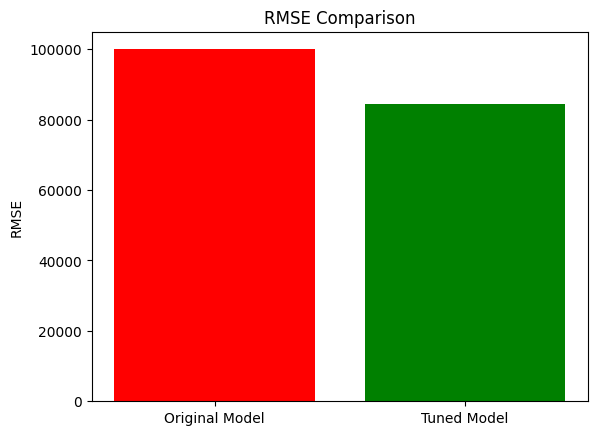

In [82]:


# RMSE from the original notebook (replace this with your recorded value)
rmse_original = 100000  

rmse_tuned = final_rmse
improvement = (rmse_original - rmse_tuned) / rmse_original * 100

print("Original RMSE:", rmse_original)
print("Tuned RMSE:", rmse_tuned)
print(f"Improvement: {improvement:.2f}%")

# Bar chart comparison
plt.bar(["Original Model", "Tuned Model"], [rmse_original, rmse_tuned], color=["red", "green"])
plt.ylabel("RMSE")
plt.title("RMSE Comparison")
plt.show()


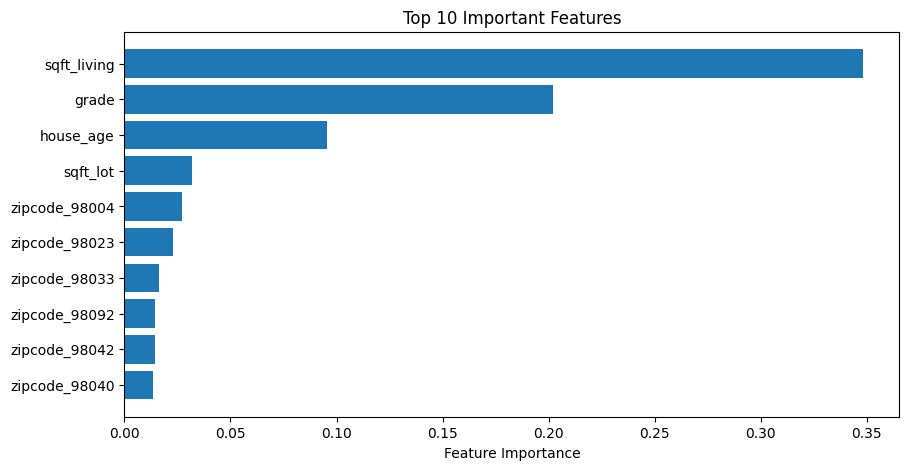

In [83]:
# Only for tree-based models
if hasattr(best_model.named_steps["regressor"], "feature_importances_"):
    importances = best_model.named_steps["regressor"].feature_importances_
    
    # Get feature names from preprocessor
    num_features_out = num_features
    cat_features_out = best_model.named_steps["preprocessor"].named_transformers_["cat"]["encoder"].get_feature_names_out(cat_features)
    passthrough_out = passthrough_features
    feature_names = np.concatenate([num_features_out, cat_features_out, passthrough_out])
    
    # Sort top 10 features
    indices = np.argsort(importances)[::-1][:10]
    
    plt.figure(figsize=(10, 5))
    plt.barh(range(len(indices)), importances[indices][::-1], align="center")
    plt.yticks(range(len(indices)), feature_names[indices][::-1])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Important Features")
    plt.show()


For the outliers, we noticed some really unrealistic values in the dataset. For example, the maximum number of bedrooms was 33, which is next to impossible in real life as most houses hardly go beyond 5 or 6 bedrooms. Such values don’t make sense and if kept, they would confuse the model, so we removed them. Similarly, in sqft_living there were houses with over 13,000 sqft, which again is very rare and doesn’t represent a normal house — these extreme values could push predictions in the wrong direction, so we removed them as well. Finally, in price, the maximum value was around 77 lakh dollars, which is extremely high compared to average houses. If we kept it, the model would start predicting higher prices even for normal houses because these huge prices pull the prediction graph upwards. That’s why we removed such outliers to make our model more realistic and better suited for predicting regular houses.